*11 Jan 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 3301 "Data Analysis in Ocean Sciences" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/academic-notes/tree/master/OCES3301_data_analysis_ocean) page.

In [1]:
# # load some deafult packages
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import fsspec

# download the eos.py from remote
try:
  import eos
except ModuleNotFoundError:
  print("loading eos.py remotely")
  !wget "https://raw.githubusercontent.com/julianmak/OCES3301_data_analysis/refs/heads/main/eos.py"
  import eos  # defining (or hiding the code for) some useful routines for calculating EOS

# pull files from the internet if needed (e.g. temporary session in Colab)
# !wget https://github.com/julianmak/OCES3301_data_analysis/raw/main/salinity_WOA13_decav_Reg1L46_clim.nc
# !wget https://github.com/julianmak/OCES3301_data_analysis/raw/main/temperature_WOA13_decav_Reg1L46_clim.nc
# !wget https://github.com/julianmak/OCES3301_data_analysis/raw/main/gebco_bathy_coarsen.nc

---------------------------

# 09: Fun with maps

Well actually not yet, leaving that till maybe next session. Lets build up to that by doing some easier things first and linking to the techniques we have encountered so far.

> ## Key Objective(s)
> 1. Introduces spatial data as multi-dimension arrays.
> 2. Demonstrate manipulation and visualisation of multi-dimension array.
> 3. Use Xarray to read NetCDF data and do manipulations/visualisations.

## a) Multi-dimensional arrays

So far we have used the data as one-dimensional arrays, either as a 1d array storing samples of data (e.g. most of the data up to `06_statistical_tets`), or as a function of time (`07/08_time_series`). We are of course not limited to dealing with 1d arrays: the categorical data before for example were really stored as **multi-dimensional arrays**, and we happen to pull them out as 1d arrays one at a time.

Multi-dimensional arrays naturally arise when we are dealing with **spatially varying** data. Since multi-dimensional arrays are usually just a collection of numbers, most of the techniques we have encountered so far work equally well for multi-dimensional arrays, albeit with some variations. Lets create an artificial example below first to demonstrate a few new things. The code below defines a spatially varying function first by specifying the co-ordinates ($x$ as `x_vec` and $y$ `y_vec`, 1d arrays), and then creating

\begin{equation*}
    f(x, y) = \sin(x) \cos(y).
\end{equation*}

We first do the "dumb" (and definitely slow) but fail safe way of creating $f$ as a 2d array, through the use of a `for` loop.

In [2]:
# simple example for a function varying in both directions
# the "dumb" (but fail proof way): using a for loop

x_vec = np.linspace(0, 2*np.pi, 21)  # use different array lengths on purpose to make sure we are not accidentally
y_vec = np.linspace(0, 2*np.pi, 26)  #   plotting against the wrong dimensions

f = np.zeros((len(y_vec), len(x_vec)))   # "back-to-front" labelling: this is for the contour plot later
for j in range(len(y_vec)):
    y = y_vec[j]
    for i in range(len(x_vec)):
        x = x_vec[i]
        f[j, i] = np.sin(x) * np.cos(y)

print(f)

[[ 0.00000000e+00  3.09016994e-01  5.87785252e-01  8.09016994e-01
   9.51056516e-01  1.00000000e+00  9.51056516e-01  8.09016994e-01
   5.87785252e-01  3.09016994e-01  1.22464680e-16 -3.09016994e-01
  -5.87785252e-01 -8.09016994e-01 -9.51056516e-01 -1.00000000e+00
  -9.51056516e-01 -8.09016994e-01 -5.87785252e-01 -3.09016994e-01
  -2.44929360e-16]
 [ 0.00000000e+00  2.99308657e-01  5.69318898e-01  7.83600238e-01
   9.21177327e-01  9.68583161e-01  9.21177327e-01  7.83600238e-01
   5.69318898e-01  2.99308657e-01  1.18617227e-16 -2.99308657e-01
  -5.69318898e-01 -7.83600238e-01 -9.21177327e-01 -9.68583161e-01
  -9.21177327e-01 -7.83600238e-01 -5.69318898e-01 -2.99308657e-01
  -2.37234454e-16]
 [ 0.00000000e+00  2.70793656e-01  5.15080143e-01  7.08946996e-01
   8.33417178e-01  8.76306680e-01  8.33417178e-01  7.08946996e-01
   5.15080143e-01  2.70793656e-01  1.07316617e-16 -2.70793656e-01
  -5.15080143e-01 -7.08946996e-01 -8.33417178e-01 -8.76306680e-01
  -8.33417178e-01 -7.08946996e-01 -5.1

The array is just a collection of numbers, where every number is some $f(x_i, y_j)$, although I have flipped the array ordering on purpose for plotting/syntax reasons. The below code plots **slices** of the the array, either as:

1) $f(x, y_j)$, i.e. $f$ as a function of $x$ at fixed $y$ (so these should be sine curves or zeros),

2) $f(x_i, y)$, i.e. $f$ as a function of $y$ at fixed $x$ (so these should be cosine curves or zeros),

3) $f(x, y)$ as a **contour** plot, i.e., each contour you see are where the function has the same value.

Below shows some syntax for the plots. Convince yourself the contour plots and the appropriate slices actually make sense.

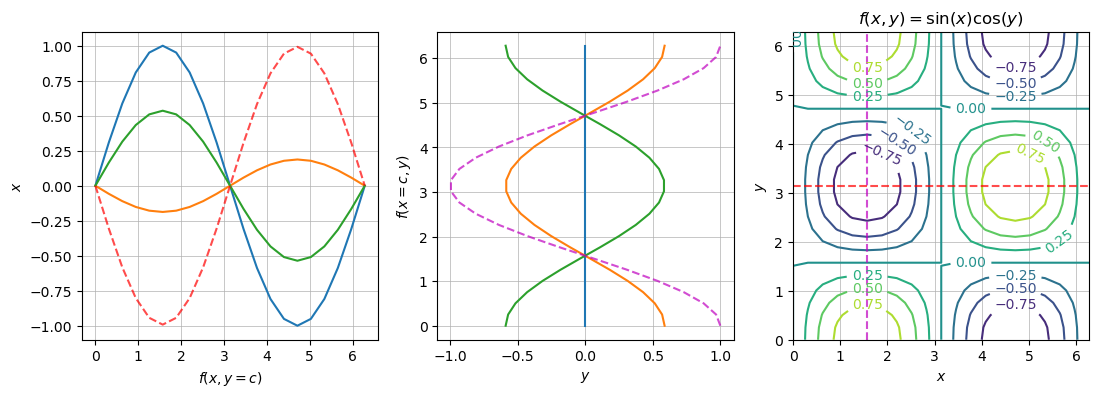

In [3]:
# plot out the above 2d array as some line plots and contour plot

fig = plt.figure(figsize=(13, 4))
ax = plt.subplot(1, 3, 1)  # f with y fixed
for j in [0, 7, 21]:
    ax.plot(x_vec, f[j, :])
ax.plot(x_vec, f[len(y_vec)//2], 'r--', alpha=0.7)
ax.set_xlabel(f"$f(x, y=c)$")
ax.set_ylabel(f"$x$")
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(1, 3, 2)  # f with x fixed
for i in [0, 8, 12]:
    ax.plot(f[:, i], y_vec)
ax.plot(f[:, len(x_vec)//4], y_vec, 'm--', alpha=0.7)
ax.set_xlabel(f"$y$")
ax.set_ylabel(f"$f(x=c, y)$")
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(1, 3, 3)  # f over x and y as contours
cs = ax.contour(x_vec, y_vec, f)
ax.plot([np.pi/2, np.pi/2], [0, 2*np.pi], 'm--', alpha=0.7)
ax.plot([0, 2*np.pi], [np.pi, np.pi], 'r--', alpha=0.7)
ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.clabel(cs)
ax.set_title(r"$f(x,y) = \sin(x)\cos(y)$")
ax.grid(lw=0.5, zorder=0)

Below code is creating the function $f$ using the `meshgrid` function: `meshgrid` takes two 1d-arrays

\begin{equation*}
    x = \begin{pmatrix}x_0 \\ x_1 \\ \vdots \\ x_{N_x}\end{pmatrix}, \qquad y = \begin{pmatrix}y_0 \\ y_1 \\ \vdots \\ y_{N_y}\end{pmatrix}
\end{equation*}

and returns two 2d-arrays as (probably this orientation, or the transpose of it depending on ordering of input)

\begin{equation*}
    \verb|xx| = \begin{pmatrix}x_0 & x_1 & \cdots & x_{N_x}\\ x_0 & x_1 & \cdots & x_{N_x}\\ \vdots & \vdots & \ddots & \vdots \\ x_0 & x_1 & \cdots & x_{N_x}\end{pmatrix}, \qquad \verb|yy| = \begin{pmatrix}y_0 & y_0 & \cdots & y_0 \\ y_1 & y_1 & \cdots & y_1 \\ \vdots & \vdots & \ddots & \vdots \\ y_{N_y} & y_{N_y} & \cdots & y_{N_y} \end{pmatrix},
\end{equation*}

so that what you end up with is something like

\begin{equation*}
    f(x, y) = \begin{pmatrix} f(x_0, y_0) & f(x_1, y_0) & \cdots & f(x_{N_x}, y_0) \\ f(x_0, y_1) & f(x_1, y_1) & \cdots & f(x_{N_x}, y_1) \\ \vdots & \vdots & \ddots & \vdots \\ f(x_0, y_{N_y}) & f(x_1, y_{N_y}) & \cdots & f(x_{N_x}, y_{N_y}) \end{pmatrix}.
\end{equation*}

Using the `meshgrid` method does the calculation essentially in one go, or as a *vector operation*. The `for` loop is fundamentally doing the same thing, but in a *sequential* fashion, i.e. one after the other as it loops around by construction.

> NOTE: `For` loops are generally slow in Python, as the language is not optimised for it. In the cases considered here it probably doesn't matter, but it is generally advisable to use vector operations when you can. There are ways to speed up `for` loops via compilation (e.g. `JIT` through `numba`) but this is beyond this course; ask me about it if you want.

The below code plots out the resulting 2d arrays of the co-ordinates ($x$ and $y$), the resulting $f$ arrays from the `for` loop and the `meshgrid`, and the difference between the two (it should be zero).

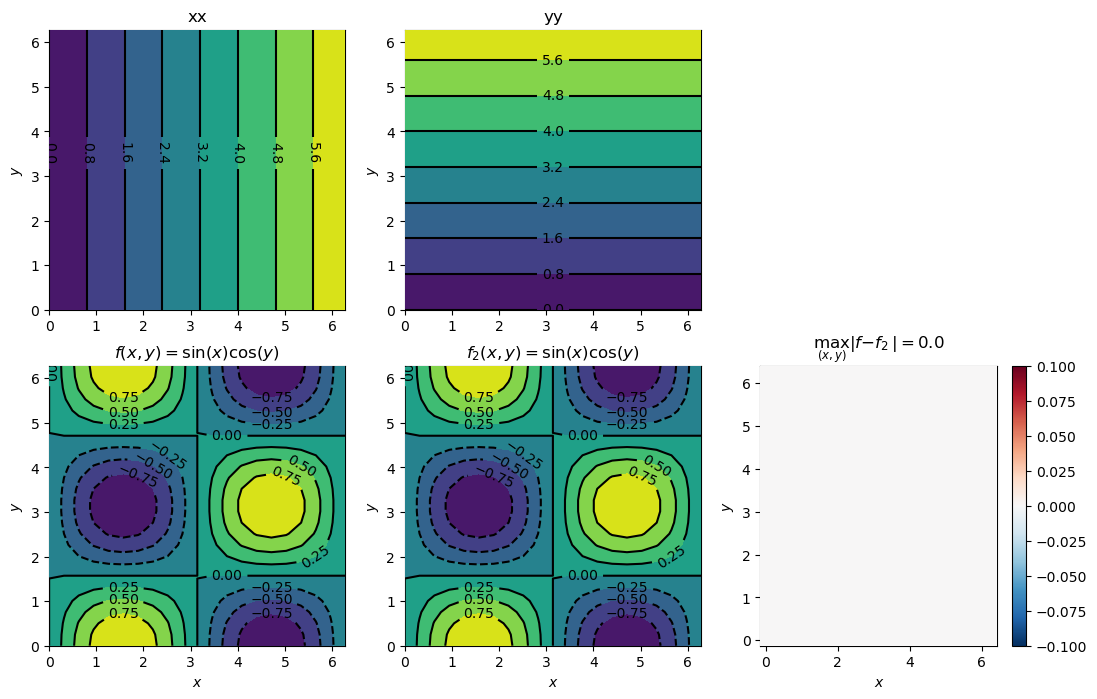

In [4]:
# same thing as above but in one go, and showing it really is identical and zero
# demonstates the use of contourf as well as pcolor

xx, yy = np.meshgrid(x_vec, y_vec)  # creates a mesh (a 2d array) from the 1d arrays
f2 = np.sin(xx) * np.cos(yy)

fig = plt.figure(figsize=(13, 8))

ax = plt.subplot(2, 3, 1)
ax.contourf(x_vec, y_vec, xx, zorder=3)
cs = ax.contour(x_vec, y_vec, xx, colors='k', zorder=3)
# ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.clabel(cs, colors="k")
ax.set_title(r"xx")
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(2, 3, 2)
ax.contourf(x_vec, y_vec, yy, zorder=3)
cs = ax.contour(x_vec, y_vec, yy, colors='k', zorder=3)
# ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.clabel(cs, colors="k")
ax.set_title(r"yy")
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(2, 3, 4)  # f over x and y as contours
ax.contourf(x_vec, y_vec, f, zorder=3)
cs = ax.contour(x_vec, y_vec, f, colors='k', zorder=3)
ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.clabel(cs, colors="k")
ax.set_title(r"$f(x,y) = \sin(x)\cos(y)$")
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(2, 3, 5)  # f2 over x and y as contours
ax.contourf(x_vec, y_vec, f2, zorder=3)
cs = ax.contour(x_vec, y_vec, f2, colors='k', zorder=3)
ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.clabel(cs, colors="k")
ax.set_title(r"$f_2(x,y) = \sin(x)\cos(y)$")
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(2, 3, 6)  # f2 over x and y as contours
cs = ax.pcolor(x_vec, y_vec, np.abs(f - f2), cmap="RdBu_r", shading="nearest", zorder=3)
ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
plt.colorbar(cs)
ax.set_title(f"$\max_{{(x,y)}}|f - f_2| = {np.max(np.abs(f - f2))}$")  # double curly brackets for f-string syntax
ax.grid(lw=0.5, zorder=0)

> NOTE: In the `for` loop, if you create the array with indexing as `f[i, j]` (so `f[x, y]` rather than `f[y, x]` like I did it), then you will need to do `plt.contourf(y_vec, x_vec, f)` (which will give you a plot but the axes are flipped) or `plt.contourf(x_vec, y_vec, f.T)`. `.T` for an array is **transpose**, and this flips the `f` array and plots the array with the "right" axes orientation. Other combinations will tell you there is an array dimension mismatch, because I made sure the arrays are rectangular rather than square on purpose to make sure that warning will trigger.
>
> This is an advice I tend to give to people for axes orientation: if you don't use a square array then you should not be running into cases where you end up getting the axes orientation wrong unintentionally.

Another way to see the contour(f) plot is as a projection or a "shadow" of a 3d plot (cf. PCA onto lower dimensions). A picture might be easier to demonstrate what I mean.

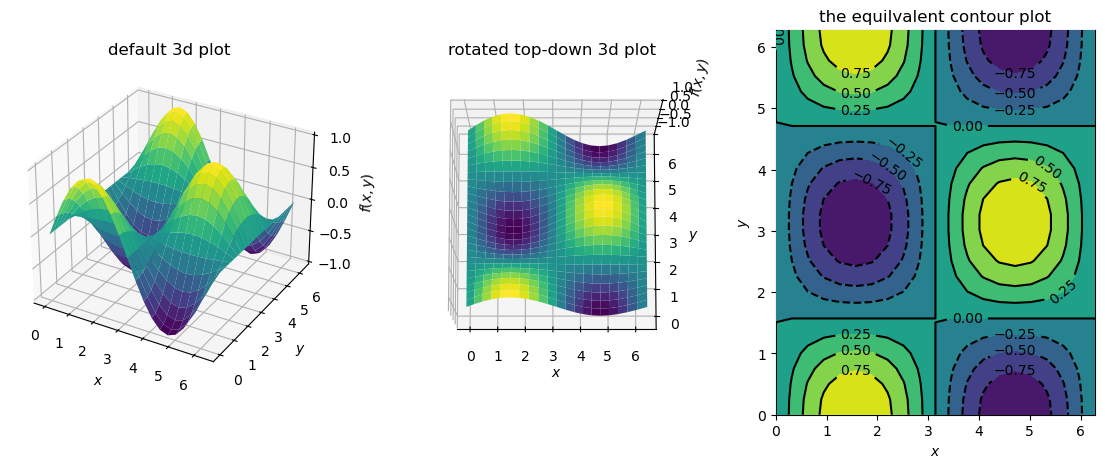

In [5]:
# 3d surf plot (seems to need a meshgrid)

xx, yy = np.meshgrid(x_vec, y_vec)

fig = plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 3, 1, projection='3d')
surf = ax.plot_surface(xx, yy, f2, cmap="viridis", zorder=3)
# ax.view_init(80, 270)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$f(x, y)$")
ax.set_title("default 3d plot")

ax = plt.subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(xx, yy, f2, cmap="viridis")
ax.view_init(80, 270)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$f(x, y)$")
ax.set_title("rotated top-down 3d plot")

ax = plt.subplot(1, 3, 3)
ax.contourf(x_vec, y_vec, f2, zorder=3)
cs = ax.contour(x_vec, y_vec, f2, colors='k', zorder=3)
ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.clabel(cs, colors="k")
ax.set_title(r"the equilvalent contour plot")
ax.grid(lw=0.5, zorder=0)

del xx, yy

## Example: equation of state

In the above case I deliberately made a variable that is a function in space, but other examples of 2d arrays exist. One ocean related example is the **equation of state**, i.e. the density $\rho$ as a function of $T$ and $S$. The example below plots out the linear equation of state (see for example OCES 2003 lecture 6)

\begin{equation*}
    \rho = \rho_0 \left[1 + \alpha(T - T_0) - \beta(S - S_0)\right],
\end{equation*}

where $\rho_0$, $T_0$ and $S_0$ are the reference density, temperature and salinity respectively, $\alpha$ is the **thermal coefficient of expansion**, and $\beta$ is the **haline coefficient of contraction**, as a contour graph.

>NOTE: The data is created is done per column, rather per point, for speed reasons.

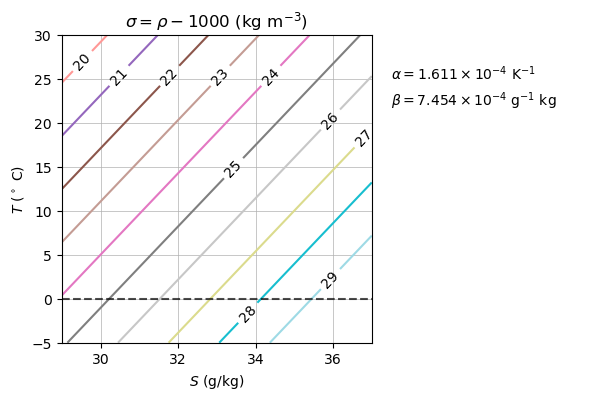

In [6]:
# linear equation of state

T_vec = np.linspace(-5, 30, 31)
S_vec = np.linspace(29, 37, 31)

rho0 = 1027.0
T0   = 10.0
S0   = 35.0
alp0 = 1.6550e-1 / rho0  # convert to the "usual" units
bet0 = 7.6554e-1 / rho0  #   (as above)

dens_lin  = np.zeros((len(T_vec), len(S_vec)))
for j in range(len(T_vec)):
    dens_lin[j, :] = rho0 * (1 - alp0 * (T_vec[j] - T0) + bet0 * (S_vec[:] - S0))  # create array per column

fig = plt.figure(figsize=(4, 4))
ax = plt.axes()
lines = ax.contour(S_vec, T_vec, dens_lin - 1000,
                   levels=np.arange(15, 30), cmap="tab20")
ax.clabel(lines, fmt="%i", colors="k")
ax.plot([29, 37], [0, 0], 'k--', alpha=0.7)
ax.set_xlabel(r"$S$ (${\rm g/kg}$)")
ax.set_ylabel(r"$T$ (${}^\circ\ {\rm C}$)")
ax.set_title(r"$\sigma = \rho - 1000$ (${\rm kg\ m^{-3}}$)")
temp = eos.get_exponent_precision(alp0, 3)
ax.text(37.5, 25, r"$\alpha = %.3f \times 10^{%i}\ {\rm K}^{-1}$" % (temp[1], temp[0]))
temp = eos.get_exponent_precision(bet0, 3)
ax.text(37.5, 22, r"$\beta = %.3f \times 10^{%i}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]))
ax.text(37.5, 13,
        r"$\nu$  $=$ $ %.3f \times 10^{%i}\ {\rm K}^{-1}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]),
       color="w")
ax.grid(lw=0.5, zorder=0)

The one below is for the **[TEOS-10](https://www.teos-10.org/)** nonlinear equation of state, using the polynomial approximation from [Roquet et al. (2015)](https://www.sciencedirect.com/science/article/pii/S1463500315000566). The routine is called from the `eos` module as `eos.sigmai_dep` (because the full code is too long).

Text(37.5, 13, '$\\nu$  $=$ $ 7.454 \\times 10^{-4}\\ {\\rm K}^{-1}\\ {\\rm g}^{-1}\\ {\\rm kg}$')

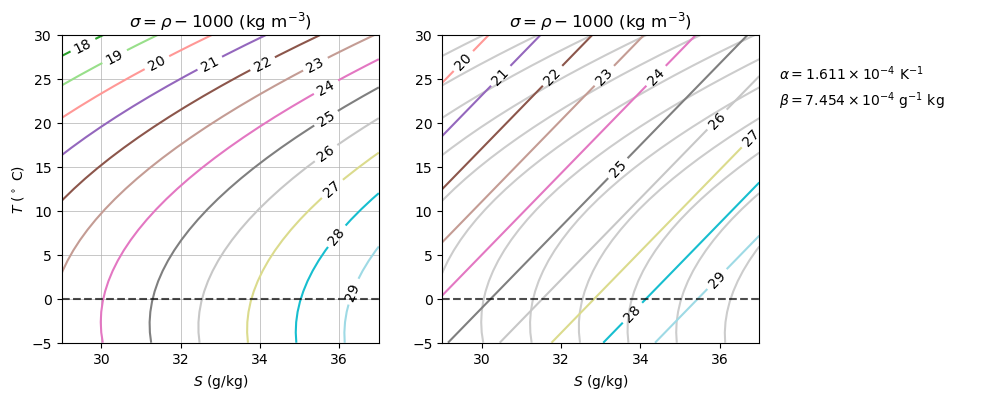

In [7]:
T_vec = np.linspace(-5, 30, 31)
S_vec = np.linspace(29, 37, 31)
dens = np.zeros((len(T_vec), len(S_vec)))
for j in range(len(T_vec)):
    dens[j, :] = eos.sigmai_dep(T_vec[j], S_vec, 0)

fig = plt.figure(figsize=(9, 4))
ax = plt.subplot(1, 2, 1)
lines = ax.contour(S_vec, T_vec, dens,   # already has the 1000 taken off
                   levels=np.arange(15, 30), cmap="tab20")
ax.clabel(lines, fmt="%i", colors="k")
ax.plot([29, 37], [0, 0], 'k--', alpha=0.7)
ax.set_xlabel(r"$S$ (${\rm g/kg}$)")
ax.set_ylabel(r"$T$ (${}^\circ\ {\rm C}$)")
ax.set_title(r"$\sigma = \rho - 1000$ (${\rm kg\ m^{-3}}$)")
ax.text(37.5, 13,
        r"$\nu$  $=$ $ %.3f \times 10^{%i}\ {\rm K}^{-1}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]),
       color="w")
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(1, 2, 2)  # plot the two together (with the TEOS-10 one as gray lines)
ax.contour(S_vec, T_vec, dens,
           levels=np.arange(15, 30), colors="k", alpha=0.2)
lines = ax.contour(S_vec, T_vec, dens_lin - 1000,
                   levels=np.arange(15, 30), cmap="tab20")
ax.clabel(lines, fmt="%i", colors="k")
ax.plot([29, 37], [0, 0], 'k--', alpha=0.7)
ax.set_xlabel(r"$S$ (${\rm g/kg}$)")
# ax.set_ylabel(r"$T$ (${}^\circ\ {\rm C}$)")
ax.set_title(r"$\sigma = \rho - 1000$ (${\rm kg\ m^{-3}}$)")
temp = eos.get_exponent_precision(alp0, 3)
ax.text(37.5, 25, r"$\alpha = %.3f \times 10^{%i}\ {\rm K}^{-1}$" % (temp[1], temp[0]))
temp = eos.get_exponent_precision(bet0, 3)
ax.text(37.5, 22, r"$\beta = %.3f \times 10^{%i}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]))
ax.text(37.5, 13,
        r"$\nu$  $=$ $ %.3f \times 10^{%i}\ {\rm K}^{-1}\ {\rm g}^{-1}\ {\rm kg}$" % (temp[1], temp[0]),
       color="w")

--------------------------
# b) Movies + animations

Movies and animations are essentially like flipbooks, and are just lots of still frames changing fast enough so it looks smooth. Below is one example of an animation that we have encountered before (from 01).

<img src="https://i.imgur.com/t4iX4Yz.gif" width="400" alt='cursed cat'>

To demonstrate some syntax, we are going to go back to the simple example above and force it to have a time-dependence via

\begin{equation*}
    f(x, y, t) = \sin(x) \cos(y) \sin(t),
\end{equation*}

i.e. it's just going to be the above diagram but oscillating in time, by augmenting to a 3d array. The below code plots out some **snapshots**, i.e. $f(x,y)$ for some fixed times.

> NOTE: Only creating a (x,y) mesh below but refraining from $t$, because the array sizes will start getting big and eat up the memory pretty quickly.

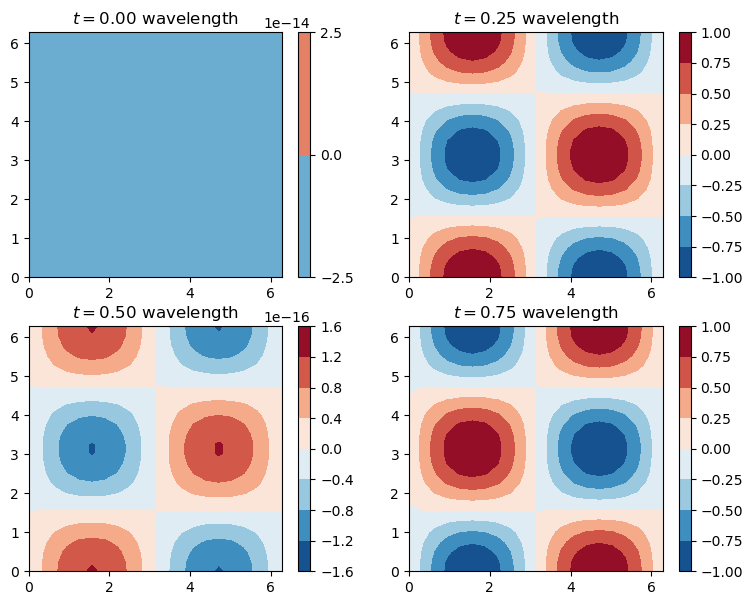

In [8]:
# snapshots with a different colour map to show oscillations

x_vec = np.linspace(0, 2*np.pi, 21)
y_vec = np.linspace(0, 2*np.pi, 26)
t_vec = np.linspace(0, 2*np.pi, 21)

xx, yy = np.meshgrid(x_vec, y_vec)  # creates a mesh (a 2d array) from the 1d arrays
f = np.zeros((len(t_vec), len(y_vec), len(x_vec)))  # use (t, y, x) ordering
for kt in range(len(t_vec)):
    t = t_vec[kt]
    f[kt, :, :] =  np.sin(xx) * np.cos(yy) * np.sin(t)

del xx, yy  # don't need these bulky variables anymore so get rid of it once we have used it for memory saving

# plot out the array as snapshots
fig = plt.figure(figsize=(9, 7))
time_dum = [0, len(t_vec)//4, len(t_vec)//2, 3*len(t_vec)//4]
for kt in range(len(time_dum)):
    ax = plt.subplot(2, 2, kt+1)
    cs = ax.contourf(x_vec, y_vec, f[time_dum[kt], :, :], cmap="RdBu_r")
    plt.colorbar(cs)
    ax.set_title(f"$t = {t_vec[time_dum[kt]] / (2*np.pi):.2f}$ wavelength")

So the function is oscillating over time (see the bottom two panels) as it should, but the plot isn't showing that very well, because by default if we don't tell `contour(f)` what contours to plot then it chooses its own from the data that it is being told to plot. One simple thing to do is to force the contours with the `levels` optional argument. In this case we know the max and min of the data array has to be between `-1` and `1` (because it's just sines and cosines), so we create an array that goes between those values; generically you might do this through trial and error, or use something like `np.max/min` to pick out the limits.

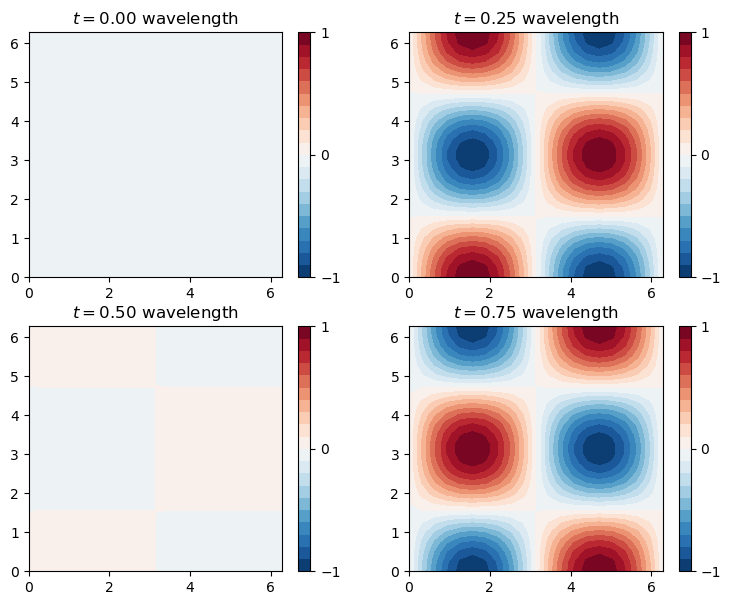

In [9]:
# plot out the array as snapshots with fixed levels

levels = np.linspace(-1, 1, 21)

fig = plt.figure(figsize=(9, 7))
time_dum = [0, len(t_vec)//4, len(t_vec)//2, 3*len(t_vec)//4]
for kt in range(len(time_dum)):
    ax = plt.subplot(2, 2, kt+1)
    cs = ax.contourf(x_vec, y_vec, f[time_dum[kt], :, :], cmap="RdBu_r", levels=levels)
    cax = plt.colorbar(cs)
    cax.set_ticks([-1, 0, 1])  # force the ticks to be at a certain place
    ax.set_title(f"$t = {t_vec[time_dum[kt]] / (2*np.pi):.2f}$ wavelength")

We can animate the above with the `animation` package. The below code shows one way of doing it, and uses the HTML package to force convert the animation into a video and display it in the notebook itself.

> NOTE: I think by default it is converting the animation into something like a `mp4` or `gif`, and this may or may not work depending on what libraries you have linked up to your Python.
>
> NOTE: I cannot figure out how to kill that extra frame that shows up. So what I am going to do is to make the animation in one cell, and call that animation in another cell.

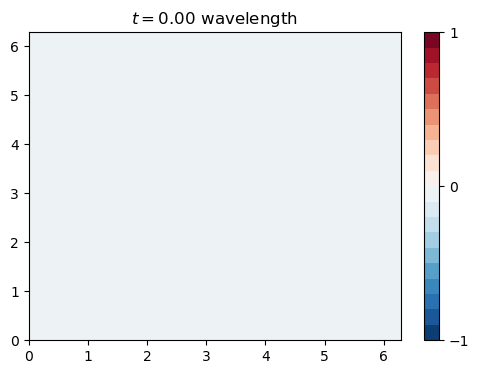

In [10]:
from matplotlib import animation
from IPython.display import HTML, Image  # force convert to a video in Jupyter

levels = np.linspace(-1, 1, 21)

fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
cs = ax.contourf(x_vec, y_vec, f[0, :, :], cmap="RdBu_r", levels=levels)
cax = plt.colorbar(cs)
cax.set_ticks([-1, 0, 1])
ax.clear()
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

def update(kt): # remove previous contours, then plot new contours
    ax.clear()
    cs = ax.contourf(x_vec, y_vec, f[kt, :, :], cmap="RdBu_r", levels=levels)
    ax.set_title(f"$t = {t_vec[kt] / (2*np.pi):.2f}$ wavelength")
    return ax

anim = animation.FuncAnimation(fig, update, frames=len(t_vec), interval=100, repeat=True);

In [11]:
# convert the animation to HTML5 video format
# HTML(anim.to_html5_video())

# if that doesn't work, could try converting to JavaScript
HTML(anim.to_jshtml())

If the conversion routines above doesn't work, try the one below, which saves it as a `gif` file, then loads it again.

> NOTE: This may not work if the `imagemagick` backend doesn't exist.

In [12]:
# save as a gif and then load it again
anim.save('animation.gif', writer='imagemagick', fps=12)
Image(url="animation.gif")

> NOTE: None of these ways are the ways I would normally use. I tend to output all of the pictures as single frames with some number indexing it, and then use some external software to compile it into a `mp4` or whatever. The reason I do this is I get a lot more control on the resulting frames, such as frame resolution etc. One thing you might see in the above is that the axes ticks are bold (particularly in the HTML5 video conversion), and this might be because there is some over-writing going on. I am sure there are ways round this, I've just never figured it out (or been sufficiently bothered by it). The code below are the kind of things I would personally do.

In [13]:
# brute force output frames and then compile it into video externally (e.g. some web application, ffmpeg, etc.)

# fig = plt.figure(figsize=(6, 4))

# for l in range(len(t_vec))
#     ax = plt.axes()
#     cs = ax.contourf(x_vec, y_vec, f[l, :, :], cmap="RdBu_r", levels=levels)
#     cax = plt.colorbar(cs[0])
#     cax.set_ticks([-1, 0, 1])
#     ax.set_xlabel(r"$x$")
#     ax.set_ylabel(r"$y$")
#     ax.set_title(f"$t = {t_vec[i] / (2*np.pi):.2f}$ wavelength")

#     # dump out figure as dummy_0001.png, dummy_0002.png, dummy_0003.png etc. (that's the "04d" bit)
#     fig.savefig(f"./pic_dump/dummy_{l:04d}.png", dpi=100, bbox_inches="tight")

#     # clear out the figure completely to make sure there is no over-writing
#     ax.clear()

# sometimes I've found I might need to clear the figure out completely, so I would include the "fig"
#   definition in the time for loop, and instead of "ax.clear()" I would do "plt.close(fig)"
# it's a bit overkill and can be a little slow, but it will definitively make sure there is no overlaying going on
# a symptom of overlaying are
#   1) the output frames become increasingly bolded
#   2) the output file size starts to creep up

--------------------------
# c) Various simple statistics

Various statistics can be done as usual, since you basically have just a large collection of numbers. The example below computes statistics per time slice for the case

\begin{equation*}
    f(x, y, t) = \sin(x) \cos(y) \sin(t)
\end{equation*}

where $\sin(t) = 1$ for simplicity (so this is at $t=\pi/2$). I am going to compute the **spatial average** as well as the **variance** at this particular time slice.

In [14]:
# mean and variance at t=pi/2, creating the function values in one go for use later
x_vec = np.linspace(0, 2*np.pi, 21)
y_vec = np.linspace(0, 2*np.pi, 26)
t_vec = np.linspace(0, 2*np.pi, 21)

xx, yy = np.meshgrid(x_vec, y_vec)
f = np.zeros((len(t_vec), len(y_vec), len(x_vec)))
for l in range(len(t_vec)):
    t = t_vec[l]
    f[l, :, :] =  np.sin(xx) * np.cos(yy) * np.sin(t)

del xx, yy

# pick out the index corresponding to t=pi/2 (which is exactly the one 1/4 along the whole length of array)
kt = len(t_vec)//4 # pick out the 1/4 index along (possibly with one offset), by doing integer division by 4
t = t_vec[kt]
f_dum = f[kt, :, :]
xbar = np.mean(f_dum.flatten())   # "flatten" the 2d array into a 1d array and take mean
ssq  = np.std(f_dum.flatten())**2 # square to get variance

print(f"======================================================")
print(f"t/(2*pi) = {t_vec[kt]/(2*np.pi):.2f}, mean of f = {xbar:.2f}, var of f = {ssq:.2f}")
print(f"======================================================")

t/(2*pi) = 0.25, mean of f = -0.00, var of f = 0.25


The mean of the function by construction is zero, so the mean is fine. The variance tells us the function is not zero at this time. On the other hand, if we take $t=\pi$ then $\sin(\pi)=0$, so the variance should be zero in this case.

In [15]:
# as above but at t=pi, where the function should be zero
kt = len(t_vec)//2 # pick out the 1/2 index along (possibly with one offset), by doing integer division by 2
t = t_vec[kt]
f_dum = f[kt, :, :]
xbar = np.mean(f_dum.flatten())   # "flatten" the 2d array into a 1d array and take mean
ssq  = np.std(f_dum.flatten())**2 # square to get variance

print(f"======================================================")
print(f"t/(2*pi) = {t_vec[kt]/(2*np.pi):.2f}, mean of f = {xbar:.2f}, var of f = {ssq:.2f}")
print(f"======================================================")

t/(2*pi) = 0.50, mean of f = -0.00, var of f = 0.00


We can then for example loop this over time and plot the mean and variance as a function of time. The mean should of course always be zero. This could be done as a `for` loop, and/or using the syntax below. Example below shows both, because the variance one doesn't quite work as straight-forwardly (see question below).

> NOTE: The `axis=0` keyword for example tells you to take an operation over the 1st axis (Python indexing). Since the data is structured as $f(t, y, x)$ in this case, this is doing the operation over the $y$-axis. Doing `axis=-1` twice means the operation is done to the last two axis twice, so in this case over $x$ and $y$, and the resulting object is a function of $t$.

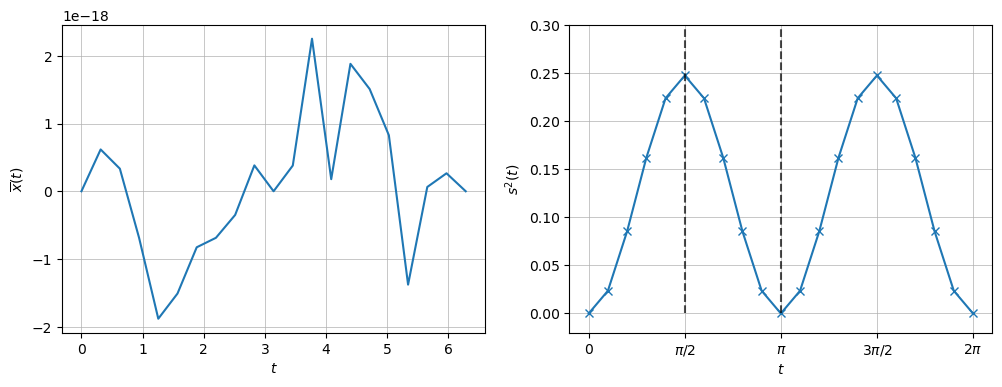

In [16]:
# as above, calculating per time
xbar = np.mean(np.mean(f, axis=-1), axis=-1)

ssq = np.zeros(len(t_vec))
for kt in range(len(t_vec)):
    ssq[kt] = np.std(f[kt, :, :].flatten())**2

fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(t_vec, xbar)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\overline{x}(t)$")
ax.grid(lw=0.5, zorder=0.5)

ax = plt.subplot(1, 2, 2)
ax.plot(t_vec, ssq, 'C0-x')
ax.set_xlabel(r"$t$")
ax.plot([np.pi/2, np.pi/2], [0, 0.3], 'k--', alpha=0.7)
ax.plot([np.pi, np.pi], [0, 0.3], 'k--', alpha=0.7)
ax.set_ylabel(r"$s^{2}(t)$")
ax.set_ylim([-0.02, 0.3])
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
ax.set_xticklabels([r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"])
ax.grid(lw=0.5, zorder=0.5)

As expected the mean is zero through the time (it's actually around $10^{-18}$ but you can regard that as essentially zero). The variance varies in time however and as expected. The variance being a squared deviation of the mean (which is zero in this case) measures where the function $\sin(x)\cos(y)\sin(t)$ is not zero, and the function is only zero when $t=n\pi$ for $n\in\mathbb{Z}$, and maximal when $t=(2m+1)/\pi$ for $m\in\mathbb{Z}$, which is exactly what the graph shows.

> <span style="color:red">**Q.**</span> Why would copying the code for `np.mean` and use for `np.std` as is and then squaring give you the WRONG answer? (Hint: have a think about the order of operation in computing the standard deviation in this case.)

> <span style="color:red">**Q.**</span> ***(Probably don't skip this exercise.)*** You of course don't have to take statistics over all of space, and you can do it over time (so a **time-average**), or over spatial slices. Try some of that yourself: for concreteness, consider doing statistics in $x$ ONLY, and plotting out the result as contours over $(t, y)$.
>
> For the function $f$, note that the average over $x$ is still zero (because average of a sine over one period is zero), but the equivalent variance will not be zero and will fluctuate in time, but will be symmetric in $y$ (because the $\cos(y)$ is symmetric in $y$).
>
> This averaging in $x$ is related to taking a **zonal average** (identifying $x$ with EW or latitude) and the **[Hovmöller diagram](https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram)** that we will visit later.

--------------------------
# d) NetCDF, `xarray`, and samples with WOA13 data

Often geophysical data is given in the [NetCDF](https://en.wikipedia.org/wiki/NetCDF) format. Without going into too much detail, NetCDF data is normally self-describing, containing within the dataset the co-ordinate files, the data itself, description of the file, units and various other attributes such as author lists and so forth. NetCDF is one of the more common formats you would find if you were to go to some geophysical data archive to get data.

Python has native NetCDF libraries to read the files. While we could use that directly, it is increasingly much easier to use the `xarray` package to read NetCDF files. `xarray` has as a dependency on the python NetCDF library. While in some sense you can think of it as a convenient front end for reading the NetCDF files, it is more powerful than that, with various capabilities that we will not use properly here, such as [lazy evaluation](https://en.wikipedia.org/wiki/Lazy_evaluation) and close links with [DASK](https://dask.org/), which is increasingly needed for cases where the dataset requires parallel computing to analyse, and/or the data itself is larger than the memory available on the computer (e.g., the NEMO ORCA0083-N01 data below is several GBs per 3d field, so you actually can't load too many at the same time, certainly not on Google Colab say).

## GEBCO data as an example

It's easier to demonstrate NetCDF and `xarray` capabilities with an example. We will start with a processed file from [GEBCO](https://www.gebco.net/data_and_products/gridded_bathymetry_data/#global), which is one of the datasets you would look up if you want to get the topography and/or bathymetry of the world.

> NOTE: Topography normally refers to above sea level, while bathymetry refers to below sea level. Sometimes "topography" is used to mean bathymetry.

Below we open the NetCDF file with xarray, and just do a simple print of the dataset.

In [17]:
# open a NetCDF file through xarray with "open_dataset"

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    file = "gebco_bathy_coarsen.nc"
elif option == "remote":
    # do a local caching (downloads a file to cache)
    print("loading data remotely")
    file_loc = "https://github.com/julianmak/OCES3301_data_analysis/raw/refs/heads/main/gebco_bathy_coarsen.nc"
    file = fsspec.open_local(f"simplecache::{file_loc}", filecache={'cache_storage': '/tmp/fsspec_cache'})
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

bathy = xr.open_dataset(file) # a dataset called "bathy"
bathy

loading data remotely


<xarray.Dataset> Size: 2MB
Dimensions:  (lat: 451, lon: 901)
Coordinates:
  * lat      (lat) float64 4kB -90.0 -89.6 -89.2 -88.8 ... 88.8 89.2 89.6 90.0
  * lon      (lon) float64 7kB -180.0 -179.6 -179.2 -178.8 ... 179.2 179.6 180.0
Data variables:
    elev     (lat, lon) float32 2MB ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO One Minute Grid - a continuous terrain model for ...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The grid is largely based on the bathymetric contours conta...
    history:      This is version 2.0 of the data set, released in November 2008
    references:   Information on the data set is available from the internet:...
    comment:      The data in the GEBCO One Minute Grid should not be used fo...
    node_offset:  0

As you can see, there are the co-ordinate variables `lat` and `lon`, the data variable called `elev` here, and it tells you `elev` is arranged as `(lat, lon)`, as `float32` (single precision data). There is a whole load of blurb available, data convention, title, and so forth (including notes I added in when I pre-processed the file; the original file is quite big).

We can query the data variables too, as below.

In [18]:
bathy["elev"]

<xarray.DataArray 'elev' (lat: 451, lon: 901)> Size: 2MB
[406351 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 4kB -90.0 -89.6 -89.2 -88.8 ... 88.8 89.2 89.6 90.0
  * lon      (lon) float64 7kB -180.0 -179.6 -179.2 -178.8 ... 179.2 179.6 180.0
Attributes:
    long_name:     Elevation relative to sea level
    units:         m
    actual_range:  [-10577.   8430.]

So the variable here is in units of meters and is relative to sea level, so that positive values are the topography while negative values are the bathymetry.

> <span style="color:red">**Q.**</span> Try querying as `bathy.elev` too (it is the same thing). Try doing the same also for `lat` and `lon`.

The variables above are given as xarray objects or xarray datasets. The way xarray works is that it doesn't load anything into memory until it absolutely has to, so if you did say `elev = bathy["elev"]`, the variable `elev` doesn't actually cost you that much memory, since it is a bit like the pointer variable you have when you open say a text file (cf. *02_reading_data_basic_manipulation*). The pointer stores a set of rules or operations to act on the data, but until you query the outcome, it hasn't actually loaded or done anything yet.

You can always force a load of the variables by doing say `elev = bathy["elev"].values`, which loads the array and now dumps it out into the `elev` variable. There are times when this is advantageous: some cases I can think of immediately are:

1) when a file is being repeatedly queried and thus involves a lot of I/O (Input/Output) and the file is small enough to load into memory

2) when you cannot get xarray to play nice with some other packages (which sometimes happens...)

3) you really just want to brute force manipulate the data as numpy arrays

We will be demonstrating uses of calling the array directly later on.

Like pandas, xarray has inbuilt functions that tries to make sensible attempts at doing things given the variables. Below example shows what happen when I get the xarray object to plot.

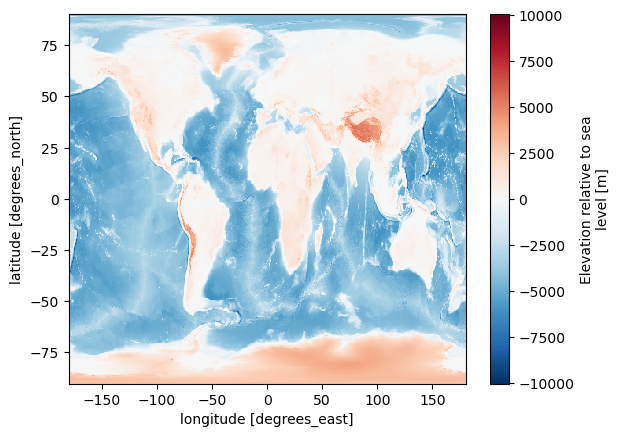

In [19]:
# simple plot: plotting the elevation against the default variables
bathy["elev"].plot()

The format here is that `bathy["elev"]` is an xarray object with imbued co-ordinates and functions, and one of them is the function `.plot()`, so `bathy["elev"].plot()` means do plot on the attached xarray object (cf. `hello = []` and then `hello.append(WHATEVER)`). The above is somewhat useful for quick plots since I don't need to be that specify about the co-ordinate axis or colour formatting.

> NOTE: The variables are only loaded when the plot command is issued. Similarly for some of the other operations acting on xarray objects.

> NOTE: We could also pass the xarray objects directly to the matplotlib commands, and have done something like `plt.pcolor(bathy["elev"])` for example. The same goes for numpy and many other python operations, though it might turn it into an array (i.e. loaded into memory) instead of an xarray object.

Below shows a slightly more decorated case using a mix of xarray and matplotlib syntax, so that I can have some control on the figure size and axes decoration.

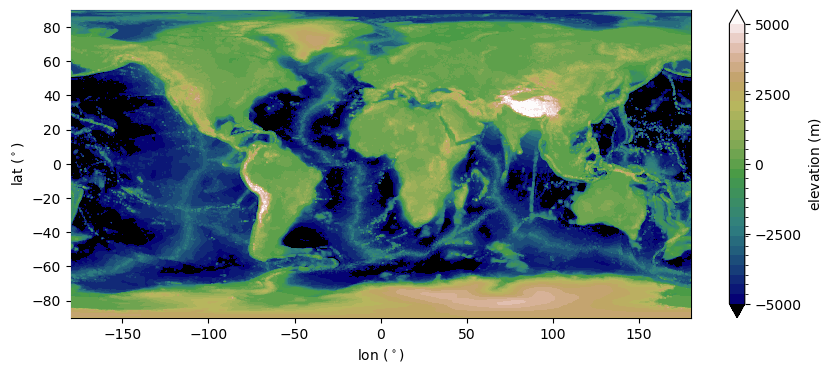

In [20]:
# slightly more advanced plot: force the figure to have certain attributes

levels = np.linspace(-5000, 5000, 30)
cbar_opts = {"ticks" : [-5000, -2500, 0, 2500, 5000],
             "label" : r"elevation ($\mathrm{m}$)"}

fig = plt.figure(figsize=(10, 4))
ax = plt.axes()
bathy["elev"].plot.contourf(   # force the plotting method
    x="lon", y="lat",          # force the x and y variables
    ax=ax,                     # force a plot on the defined axis "ax"
    cmap="gist_earth",         # force a colormap
    levels=levels,             # force the contour levels
    cbar_kwargs=cbar_opts,     # force colorbar attributes
    zorder=3)
ax.set_xlabel(r"lon (${}^\circ$)")
ax.set_ylabel(r"lat (${}^\circ$)")
ax.grid(lw=0.5, zorder=0)

Below gives an example of an operation on the array. Here, `xr.where` is a conditional command that works as `xr.where(condition, value if true, value if false)`, which is exactly like the `np.where` command. The difference here is that `xr.where` returns an xarray object, while `np.where` will return an array.

In the below I am going to wipe out the positive values, and so only plotting the bathymetry. The way I am doing this is to set everything above sea level to be NaN (not a number), which is generally ignored by plotting commands. I am also going to add a minus sign so that I am now plotting the ocean depth.

<xarray.DataArray 'elev' (lat: 451, lon: 901)> Size: 2MB
array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [2974., 2976., 2979., ..., 2981., 2978., 2974.],
       [4169., 4169., 4169., ..., 4170., 4169., 4169.],
       [4227., 4227., 4227., ..., 4227., 4227., 4227.]],
      shape=(451, 901), dtype=float32)
Coordinates:
  * lat      (lat) float64 4kB -90.0 -89.6 -89.2 -88.8 ... 88.8 89.2 89.6 90.0
  * lon      (lon) float64 7kB -180.0 -179.6 -179.2 -178.8 ... 179.2 179.6 180.0


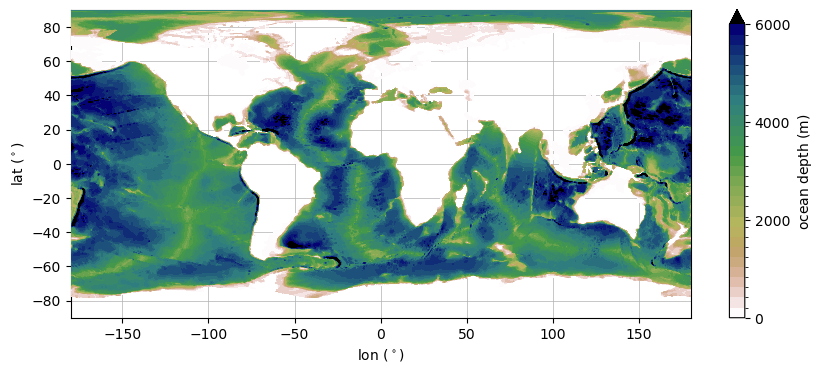

In [21]:
# example: kill off the positive values and only plot the ocean DEPTH

ocean_bathy = xr.where(bathy["elev"] < 0, -bathy["elev"], np.nan)  # nan out some stuff, and add minus sign
print(ocean_bathy)

levels = np.linspace(0, 6000, 30)
cbar_opts = {"ticks" : [0, 2000, 4000, 6000],
             "label" : r"ocean depth ($\mathrm{m}$)"}

fig = plt.figure(figsize=(10, 4))
ax = plt.axes()
ocean_bathy.plot.contourf(ax=ax, x="lon", y="lat", cmap="gist_earth_r",
                          levels=levels, cbar_kwargs=cbar_opts, zorder=3)
ax.set_xlabel(r"lon (${}^\circ$)")
ax.set_ylabel(r"lat (${}^\circ$)")
ax.grid(lw=0.5, zorder=0)

## WOA13 data

In the below I am going to load the [World Ocean Atlas 2013 (WOA13)](https://www.nodc.noaa.gov/OC5/woa13/) data, which I must have got from the repository at some point, but I honestly don't remember... the file below has been slightly processed by reducing the spatial resolution, changing the vertical spacing somewhat, and changing the variable names I think (I needed this for numerical model simulations). The below code reads the files through xarray and outputs some of the meta data from the files.

> NOTE: loading these files may be a little slow, because the file sizes are not negligible. Can speed it up by downloading the file once and for all with `!wget`, and then using the `local` option. (The remote load option is already downloading a file, it's just not saving it.

In [22]:
# load the temperature and salinity profiles

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    file_theta = "temperature_WOA13_decav_Reg1L46_clim.nc"
    file_salin = "salinity_WOA13_decav_Reg1L46_clim.nc"
elif option == "remote":
    # do a local caching (downloads a file to cache)
    print("loading data remotely")
    file_loc = "https://github.com/julianmak/OCES3301_data_analysis/raw/refs/heads/main/temperature_WOA13_decav_Reg1L46_clim.nc"
    file_theta = fsspec.open_local(f"simplecache::{file_loc}", filecache={'cache_storage': '/tmp/fsspec_cache'})
    file_loc = "https://github.com/julianmak/OCES3301_data_analysis/raw/refs/heads/main/salinity_WOA13_decav_Reg1L46_clim.nc"
    file_salin = fsspec.open_local(f"simplecache::{file_loc}", filecache={'cache_storage': '/tmp/fsspec_cache'})
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

toce_WOA13 = xr.open_dataset(file_theta)
soce_WOA13 = xr.open_dataset(file_salin)

print(f"======================================================")
print(r"1) conservative temperature outline (called `votemper` here, inline with CMIP5 convention)")
print(" ")
print(toce_WOA13)
print(" ")
print(f"======================================================")
print(r"2) absolute salinity outline (called `vosaline` here, inline with CMIP5 convention)")
print(" ")
print(soce_WOA13)

loading data remotely
1) conservative temperature outline (called `votemper` here, inline with CMIP5 convention)
 
<xarray.Dataset> Size: 143MB
Dimensions:   (lat: 180, lon: 360, lev: 46, time: 12)
Coordinates:
  * lat       (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lev       (lev) float32 184B 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time      (time) float32 48B 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    votemper  (time, lev, lat, lon) float32 143MB ...
Attributes:
    title:    homebrew forcing files for ORCA1 config
 
2) absolute salinity outline (called `vosaline` here, inline with CMIP5 convention)
 
<xarray.Dataset> Size: 143MB
Dimensions:   (lat: 180, lon: 360, lev: 46, time: 12)
Coordinates:
  * lat       (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  

The (conservative) temperature variable here is called `votemper`, while the (absolute) salinity variable is called `vosaline` (these are in line with the CMIP5 variable conventions). These are monthly climatological data, i.e. "typical" temperature/salinity distributions in space at monthly resolution.

So one thing we might be interested is to plot the seasonal variations of the temperature/salinity **vertical profile** (i.e. as a function of depth), at some particular location (so fixing $x, y, t$, and plotting against depth). For some choice of intended (lon, lat) we would normally have to first find the appropriate index corresponding to our intended (lon, lat), through either looking by eye, or using conditionals like `np.where`. xarray actually has these query functions built in, for example the imbued function `.sel()`. The below syntax uses `toce.sel(lon=target_lon, ..., method="nearest")` i.e. in the xrray object named `toce`, pick out for me the data at the dimension `lon` nearest to the value `target_lon` that I specify. Below plots the (Northern Hemisphere) summer and winter temperature profiles at the [PAPA station](https://www.pmel.noaa.gov/ocs/Papa) location.

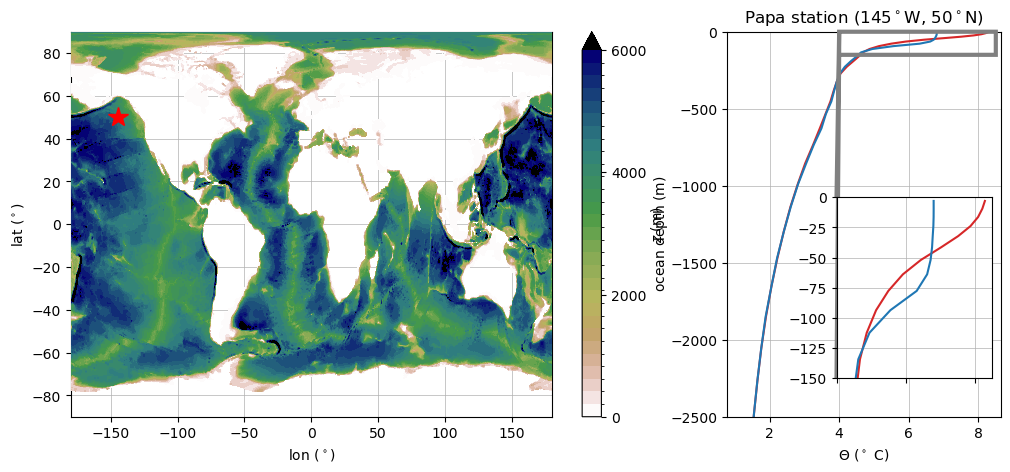

In [23]:
# do some verical plots of (conservative) temperature
# useful locations: station Papa at 145W 50N
#                   Kuroshio extension observatory at 144E 32N
#                   south of HK 115E 21N

toce = toce_WOA13["votemper"]
z = -toce_WOA13["lev"].values
target_lon, target_lat = -145, 50

fig = plt.figure(figsize=(12, 5))

ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ocean_bathy.plot.contourf(ax=ax, x="lon", y="lat", cmap="gist_earth_r",
                          levels=levels, cbar_kwargs=cbar_opts, zorder=3)
ax.plot(ocean_bathy.lon.sel(lon=-145, method="nearest"),
        ocean_bathy.lat.sel(lat=50, method="nearest"),
        "r*", markersize=15, zorder=3)
ax.set_xlabel(r"lon (${}^\circ$)")
ax.set_ylabel(r"lat (${}^\circ$)")
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax.plot(toce.sel(lon=target_lon, lat=target_lat, time=6, method="nearest"), z, color="C3")  # summer
ax.plot(toce.sel(lon=target_lon, lat=target_lat, time=12, method="nearest"), z)             # winter
ax.set_ylim(-2500, 0)
ax.set_xlabel(r"$\Theta$ (${}^\circ\ {\rm C}$)")
ax.set_ylabel(r"$z$ (${\rm m}$)")
ax.grid(lw=0.5, zorder=0)
axins = ax.inset_axes([0.4, 0.1, 0.57, 0.47])
axins.plot(toce.sel(lon=target_lon, lat=target_lat, time=6, method="nearest"), z, color="C3")  # summer
axins.plot(toce.sel(lon=target_lon, lat=target_lat, time=12, method="nearest"), z)             # winter
axins.set_xlim(4, 8.5)
axins.set_ylim(-150, 0)
axins.set_xticklabels([])
axins.grid(lw=0.5, zorder=0)
ax.indicate_inset_zoom(axins, lw=3, alpha=1)

if target_lon > 0:
    lon_str = f"{target_lon}$^\circ$E"
else:
    lon_str = f"{np.abs(target_lon)}$^\circ$W"

if target_lat > 0:
    lat_str = f"{target_lat}$^\circ$N"
else:
    lat_str = f"{np.abs(target_lar)}$^\circ$S"
ax.set_title(f"Papa station ({lon_str}, {lat_str})");

> <span style="color:red">**Q.**</span> Try something similar for other locations, and for salinity too. Some notable locations for salinity might be
> 1. Tropical Pacific 117E 0N  (salty because large EmP)
> 2. Weddell sea 45E 71S       (ice governed)
> 3. pearl river 113E 22N      (estuary environment)
>
> See [lec05 of OCES 2003](https://github.com/julianmak/OCES2003_descriptive_po/blob/main/OCES2003_05.pdf) for the kind of outputs you might expect (it's towards the latter part of the lecture slides). Try and maybe reproduce some of the graphs there.

Instead of vertical profiles we could also plot **meridional sections** (i.e. data varying in latitude and depth). We are going to plot here the **time-averaged** meridional section, by averaging the data in time, selecting a target longitude, and then plotting the results. The time-averaging is done over the whole 12 months through the imbued function `toce_WOA13["votemper"].mean(dim="time")`, which here means for the xarray object `toce_WOA13["votemper"]`, find me the average over the dimension `time`.

> NOTE: To do time averaging through numpy if we wanted to do that, we note that the variables are in dimension (t, z, y, t), so we want to do an average over the first dimension, i.e. `np.mean(toce_WOA13["votemper"], axis=0)`.

Text(0, 0.5, '$S_A$ (${\\rm g/kg}$)')

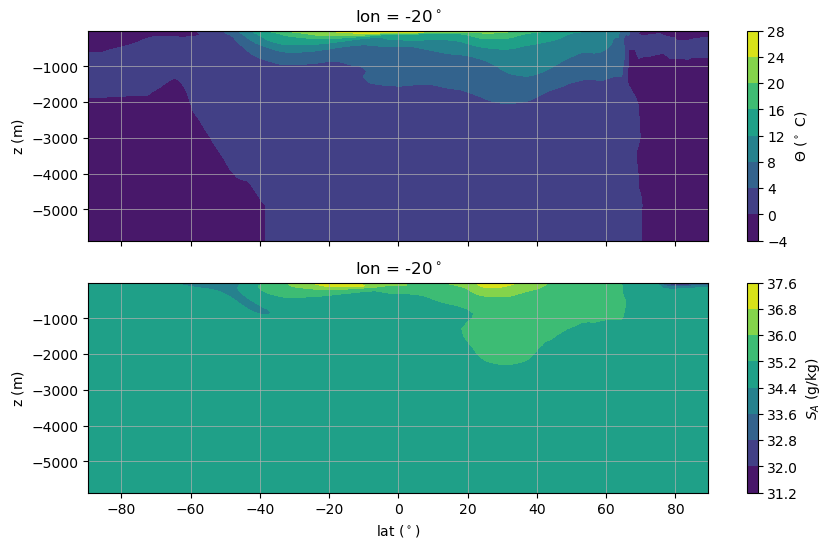

In [24]:
# meridional section in a similar way, but no mask for now
# additionally demonstrate time-averaging data

toce = toce_WOA13["votemper"].mean(dim="time")  # averaging over all time (in this case the year)
soce = soce_WOA13["vosaline"].mean(dim="time")  # note it was (t,z,y,x), now it is (z,y,x)

target_lon = -20  # a slice in the Atlantic
actual_lon = soce.sel(lon=target_lon, method="nearest")["lon"].values  # pull out the numbers into array
lat =  soce["lat"].values
z   = -soce["lev"].values

toce_slice  = toce.sel(lon=target_lon, method="nearest")  # note this is now (z, y) since I selected an x
soce_slice  = soce.sel(lon=target_lon, method="nearest")

fig = plt.figure(figsize=(10, 6))

# temperature
ax = plt.subplot(2, 1, 1)
cs = ax.contourf(lat, z, toce_slice)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_title(f"lon = {actual_lon:.0f}$^\circ$")
ax.grid(lw=0.5, zorder=0)
ax.set_xticklabels([])

cax = plt.colorbar(cs)
cax.ax.set_ylabel(r"$\Theta$ (${}^\circ\ {\rm C}$)")

# salinity
ax = plt.subplot(2, 1, 2)
cs = ax.contourf(lat, z, soce_slice)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_title(f"lon = {actual_lon:.0f}$^\circ$")
ax.grid(lw=0.5, zorder=0)
ax.set_xlabel(r"lat (${}^\circ$)")

cax = plt.colorbar(cs)
cax.ax.set_ylabel(r"$S_A$ (${\rm g/kg}$)")

Can't really see anything right? In particular, there is no hint of bottom bathymetry here...

The data here has not been *a priori* processed to include the land points, which would normally be NaNs or something corresponding to **missing values** (cf. `-99.99` in the El-Nino 3.4 SST data we have been using). In the below I am going to put this in *ad hoc*, using the above GEBCO data. What I am going to do for the meridional case is to find say what my `target_lon` is, find the corresponding data for both the WOA13 data and the GEBCO data, and cycle through the latitudes. At a particular latitude, I find the corresponding GEBCO depth, and set anything below that depth to be NaN (via a conditional). The result is given below.

> NOTE: There is likely a slight mismatch between the actual longitude and latitude values used, so this is only really an approximation, but since we are only using this for visualisation rather than calculations as such it probably doesn't matter very much.

Text(0, 0.5, '$S_A$ (${\\rm g/kg}$)')

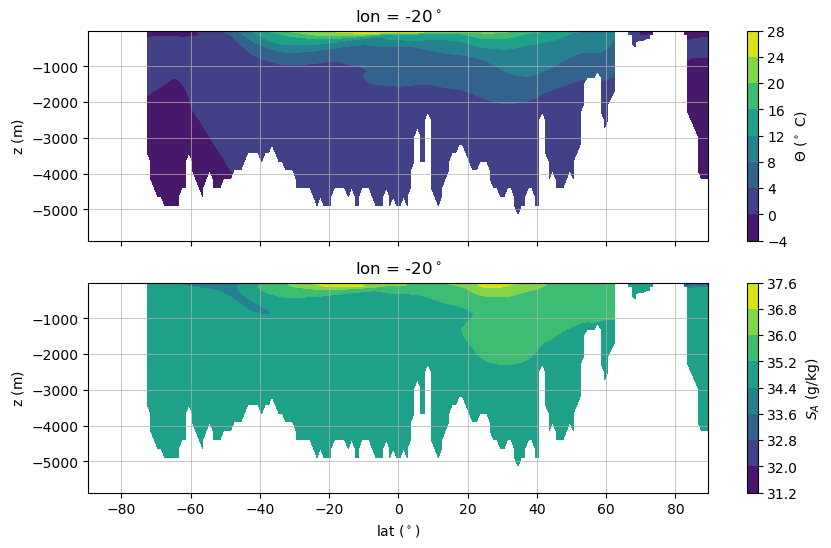

In [25]:
# put on some land
# create a mask based on the bathymetry file, set array values to be NaNs where it coincides with mask

target_lon = -20  # a slice in the Atlantic
actual_lon = soce.sel(lon=target_lon, method="nearest")["lon"].values  # pull out the numbers into array
lat =  soce["lat"].values
z   = -soce["lev"].values  # minus sign to make this consistent with GEBCO data

# do a masking based on the GEBCO data: find GEBCO depth, set all data below that depth to be NaN
# open bathy if needed
for j in range(len(lat)):
    mask_value = bathy["elev"].sel(lon=target_lon, lat=lat[j], method="nearest").data
    soce_slice[(z < mask_value), j] = np.nan
    toce_slice[(z < mask_value), j] = np.nan

# plotting as usual
fig = plt.figure(figsize=(10, 6))

# temperature
ax = plt.subplot(2, 1, 1)
cs = ax.contourf(lat, z, toce_slice)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_title(f"lon = {actual_lon:.0f}$^\circ$")
ax.grid(lw=0.5, zorder=0)
ax.set_xticklabels([])

cax = plt.colorbar(cs)
cax.ax.set_ylabel(r"$\Theta$ (${}^\circ\ {\rm C}$)")

# salinity
ax = plt.subplot(2, 1, 2)
cs = ax.contourf(lat, z, soce_slice)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_title(f"lon = {actual_lon:.0f}$^\circ$")
ax.grid(lw=0.5, zorder=0)
ax.set_xlabel(r"lat (${}^\circ$)")

cax = plt.colorbar(cs)
cax.ax.set_ylabel(r"$S_A$ (${\rm g/kg}$)")

Below code formats the plots a bit more.

Text(0, 0.5, '$S_A$ (${\\rm g/kg}$)')

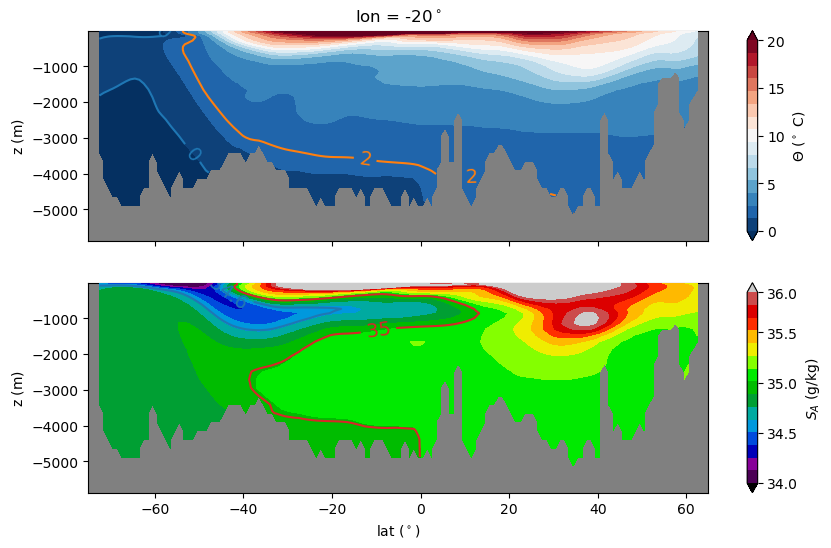

In [26]:
# make the plots look less shit

toce_opt = {"levels" : np.linspace(0, 20, 16),
           "cmap"    : "RdBu_r",
           "extend"  : "both",
           }

soce_opt = {"levels" : np.linspace(34, 35.9, 16),
           "cmap"    : "nipy_spectral",
           "extend"  : "both",
           }

fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(2, 1, 1)
cs = ax.contourf(lat, z, toce_slice, **toce_opt, zorder=3)
line = ax.contour(lat, z, toce_slice, levels=[2], colors="C1", zorder=3)
ax.clabel(line, fmt = r"$2$", colors="C1", fontsize=14, zorder=3)
line = ax.contour(lat, z, toce_slice, levels=[0], colors="C0", zorder=3)
ax.clabel(line, fmt = r"$0$", colors="C0", fontsize=14, zorder=3)
ax.set_xlim(-75, 65)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_title(f"lon = {actual_lon:.0f}$^\circ$")
ax.set_xticklabels([])
ax.set_facecolor('gray')
cax = plt.colorbar(cs)
cax.set_ticks(np.arange(0, 21, 5))
cax.ax.set_ylabel(r"$\Theta$ (${}^\circ\ {\rm C}$)")
# ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(2, 1, 2)
cs = ax.contourf(lat, z, soce_slice, **soce_opt, zorder=3)
line = ax.contour(lat, z, soce_slice, levels=[35], colors="C3", zorder=3)
ax.clabel(line, fmt = r"$35$", colors="C3", fontsize=14, zorder=3)
line = ax.contour(lat, z, soce_slice, levels=[34.6], colors="C0", zorder=3)
ax.clabel(line, fmt = r"$34.6$", colors="C0", fontsize=14, zorder=3)
ax.set_xlim(-75, 65)
ax.set_ylabel(r"z (${\rm m}$)")
ax.set_xlabel(r"lat (${}^\circ$)")
ax.set_facecolor('gray')
# ax.grid(lw=0.5, zorder=4)
cax = plt.colorbar(cs)
cax.set_ticks(np.arange(34, 36.1, 0.5))
cax.ax.set_ylabel(r"$S_A$ (${\rm g/kg}$)")

For the temperature we see that it is largest at the surface and decreases as depth increases (no surprises there really). I plotted both the 0 and 2 degree **isotherm** on as labelled contours. The water can be below zero degrees in the ocean because there is salinity, so the water is not necessarily freezing (it is *freshwater* that freezes at zero degrees, and that is also assuming we are at sensible pressures). The extrusion of sorts of the 2 degree isotherm from the Southern Ocean particularly at depth indicates there is some export of particularly cold and dense water from the South towards the North in the abyssal ocean; this is usually attributed to the AABW (Antarctic Bottom Water).

For the salinity, two notable features are the salty blobs (technical language here) that seem to extend from the Northern Hemisphere mid-latitudes in the deeper parts of the ocean towards the South, and fresh regions originating from the Southern Ocean that is running at the upper-mid depths, underneath the surface salty water in the lower latitudes. These are part of the overturning circulation, and are normally associated with the NADW (North Atlantic Deep Water) and the AAIW (Antarctic Intermediate Water). See [lec05 of OCES 2003](https://github.com/julianmak/OCES2003_descriptive_po/blob/main/OCES2003_05.pdf) if you haven't seen these before (you should have if you are a OCES student).

Instead of meridional sections we can do horizontal plots, i.e. plotting function varying in $x$ and $y$ at fixed $t$ and $z$. The slight annoyance here is the masking. The problem of sorts here is that the GEBCO and WOA13 data have entries located at non-overlapping co-ordinates (which is generic when using datasets). Using the surface plot as an example, the simple way of constructing the mask would be as follows:

1) loading every point of the WOA13 data and finding its co-ordinates

2) make a query for the closest index to that co-ordinate on the GEBCO grid

3) check whether GEBCO data is positive (i.e. land) or not, if so, return 0 (`False`, not ocean point), otherwise return 1 (`True`, ocean point)

This would be done generically at every single vertical level if a 3d mask is to constructed this way. The procedure as detailed is going to be painfully slow because:

1) this is a brute force search done in a sequential fashion, written over some `for` loops

2) an I/O might need to be done at every point within the `for` loop

While the latter we can get around somewhat by loading the data into memory, as well as saving the mask separately to re-use (you really don't want to generate a global mask this way on the fly), the first part is somewhat fundamental and we can't get away from that unless we use a different method.

> NOTE: This is the issue of **algorithmic complexity**: one might expect since there are three dimensions (assuming the land does not vary in $t$), the number of operations we need to do with this algorithms minimally scales like $N_x \times N_y \times N_z$ because of the `for` loop, so mild increases in spatial resolution would increase the computation cost drastically.
>
> (I am using "minimally" here because I haven't accounted for the brute force search of the index itself, which is also slow.)

With the above in mind, I am going to create the mask on the fly over a small region, and only for the surface. The below code uses the brute force algorithm detailed above, but does a search only over the North Atlantic region. Even then you should notice the code is a bit slow. I am creating the mask, saving it in memory, and then using it in plots and calculations in the later cells.

In [27]:
# creating a mask only for the surface over the North Atlantic  (80 W to 10 E), (0 to 65 N)

# NOTE: algorithmically the below procedure is kind of dumb and will be slow
#       don't recommend doing this repeatedly to be honest

toce = toce_WOA13["votemper"].mean(dim="time")  # averaging over all time (in this case the year)

# averaged in time and selecting surface slice, so this is data in (y,x)
# going to directly pull out the values here and manipulate the array directly to avoid I/O in for loop below
toce_surf = toce.isel(lev=0).values

# mask out the data again based on GEBCO
lon =  toce["lon"].values
lat =  toce["lat"].values
z   = -toce["lev"].values  # minus sign to make this consistent with GEBCO data

# pull out the indices associated with the regional box of interest
# NOTE: don't make this too big because the procedure is then absolutely crawling
#   (because the below is a "stupid" way of doing it)
target_lon_l, target_lon_r = -80, 10
target_lat_b, target_lat_t = 0, 65
lon_index = np.where((lon > target_lon_l) & (lon < target_lon_r))[0]
lat_index = np.where((lat > target_lat_b) & (lat < target_lat_t))[0]

# do a masking based on the GEBCO data: find GEBCO depth, if ocean set to 1, if land then set to 0
# grid mismatch between GEBCO and WOA13 data here, so can't use xr.where
# just going to do the dumb thing and cycle it in a for loop

land_mask = np.zeros(toce_surf.shape)  # initialise to a load of ones (assume everything is land first)
for i in range(lon_index[0], lon_index[-1]+1):
    for j in range(lat_index[0], lat_index[-1]+1):
        mask_value = bathy["elev"].sel(lon=lon[i], lat=lat[j], method="nearest").data
        if mask_value <= 0:
            land_mask[j, i] = 1        # set points to ocean if bathy["elev"] is negative or zero

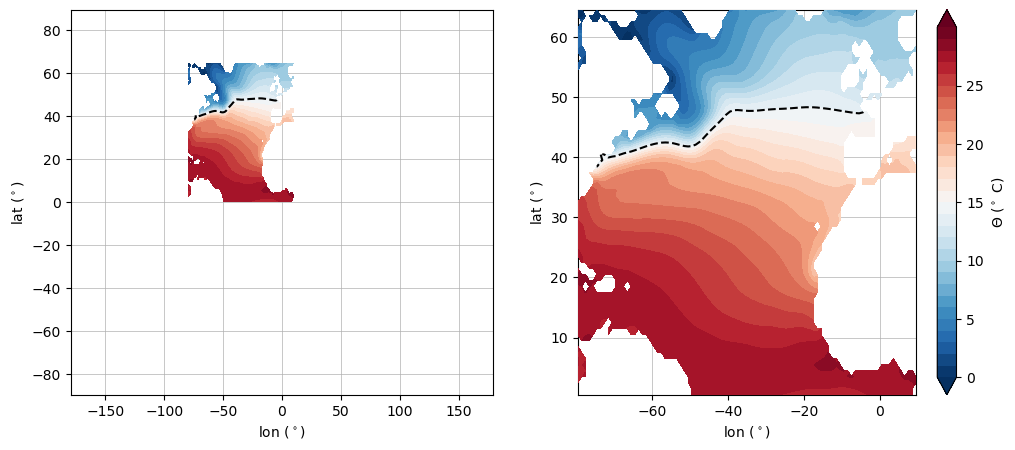

In [28]:
# plot out the data: set all the land points based on the mask to be NaN

toce_dummy = np.where(land_mask == 1, toce_surf, np.nan)  # use the defined land mask to NaN things out

toce_opt = {"levels" : np.linspace(0, 30, 31),
           "cmap"    : "RdBu_r",
           "extend"  : "both",
           }

fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
cs = ax.contourf(lon, lat, toce_dummy, **toce_opt, zorder=3)
line = ax.contour(lon, lat, toce_dummy, levels=[14], colors="k", linestyles="--", zorder=3)
ax.set_xlabel(r"lon (${}^\circ$)")
ax.set_ylabel(r"lat (${}^\circ$)")

# ax.set_facecolor('gray')
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(1, 2, 2)
cs = ax.contourf(lon, lat, toce_dummy, **toce_opt, zorder=3)
line = ax.contour(lon, lat, toce_dummy, levels=[14], colors="k", linestyles="--", zorder=3)
ax.set_xlim(lon[lon_index[0]], lon[lon_index[-1]])  # pull out the corresponding limits in lon and lat
ax.set_ylim(lat[lat_index[0]], lat[lat_index[-1]])
ax.set_xlabel(r"lon (${}^\circ$)")
ax.set_ylabel(r"lat (${}^\circ$)")

cax = plt.colorbar(cs)
cax.set_ticks(np.arange(0, 30, 5))
cax.ax.set_ylabel(r"$\Theta$ (${}^\circ\ {\rm C}$)")

# ax.set_facecolor('gray')
ax.grid(lw=0.5, zorder=0)

In the above I have NaNed out everywhere except the North Atlantic, and I plotted a black dashed line that would be suggestive of the Gulf Stream, since these are regions with a reasonably large horizontal gradient, and **thermal wind** shear relation should hold (do a Google search or check [lec08](https://github.com/julianmak/OCES2003_descriptive_po/blob/main/OCES2003_08.pdf) and/or [lec13](https://github.com/julianmak/OCES2003_descriptive_po/blob/main/OCES2003_13.pdf) of OCES 2003 if you don't know/remember what that is).

> NOTE: The line here is calibrated by hand here, but can be done better, for example by taking the horizontal derivative of the data (so get the gradient), and plot of the regions with the largest gradients. However, to do this you probably want the **grid spacings** (the **metric**), which needs to be artificially generated.

The below code does two averaging calculations based on the mask. The first one is a **(horizontal) domain average**, which for the conservative temperature $\Theta$ is given by

\begin{equation*}
    \langle \Theta \rangle = \frac{1}{A} \iint \Theta\; \mathrm{d}\boldsymbol{A} = \frac{1}{A} \iint \Theta\; \mathrm{d}x\; \mathrm{d}y.
\end{equation*}

The other one is a **zonal average**, given by

\begin{equation*}
    \overline{\Theta} = \frac{1}{L_x} \int \Theta\; \mathrm{d}x.
\end{equation*}

I did the averaging below with a mix of xarray and numpy operations, in particular using

* `np.nanmean`, which is a mean but ignoring `NaN` values (can be given optional argument `axis=INDEX` to specify axis

* `.mean(dim="lon", skipna=True)`, which is a mean over the longitude dimension, skipping NaN values

So here we do actually need deal with the presence of NaNs: notice that the (NaN) average of $\{1, 2, 3, \mathrm{NaN}\}$ would be $(1+2+3)/3 = 2$, while for $\{1, 2, 3, 0\}$ this would be $(1+2+3+0)/4 = 1.5$. Setting the values to NaNs means it never gets taken into account in the averaging procedure, which really is what we want here. The below shows the domain average as a function of time, and a zonal average as a function of time (a **Hovmöller diagram**).

> NOTE: I have done something that is close to a domain and zonal average, because I haven't calculated the lengths and areas properly here. To do that you need the metric variables, which means you need to have some grid spacings in the first place. Remembering that for fixed lon/lat spacings, the associated area/lengths *decrease* as you move from the equator (see also *10_fun_with_maps*). For leading order estimates this is probably fine, but for actual quantification more care will be required.

Text(0, 0.5, '$\\Theta$ (${}^\\circ\\ {\\rm C}$)')

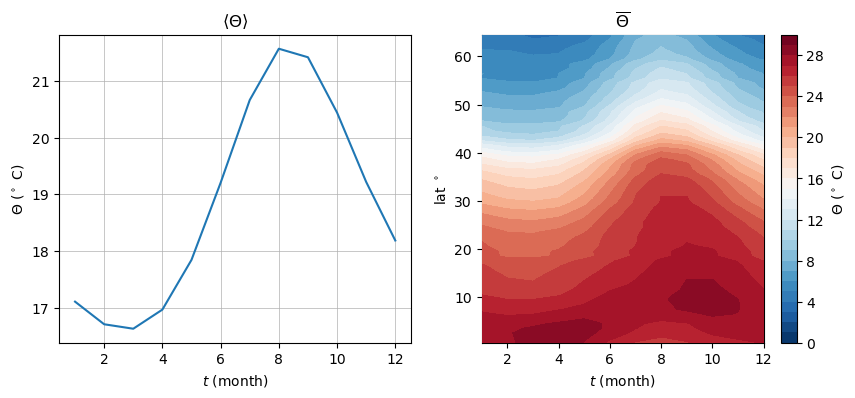

In [29]:
# use the computed regional mask to compute the N. Altantic avreaged temperature as a function of months

t_domain_avg_NATL = []
t_zonal_avg_NATL  = []
for kt in range(0, 12):  # monthly data
    dummy = toce_WOA13["votemper"].isel(lev=0, time=kt)   # pick out the slice
    t_domain_avg_NATL.append(np.nanmean(np.nanmean(np.where(land_mask == 1, dummy, np.nan))))
    t_zonal_avg_NATL.append((xr.where(land_mask==1, dummy, np.nan).mean(dim="lon", skipna=True)).values)

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
ax.plot(np.arange(1, 12+1), t_domain_avg_NATL, zorder=3)
ax.set_xlabel("$t$ (month)")
ax.set_ylabel(r"$\Theta$ (${}^\circ\ {\rm C}$)")
ax.set_title(r"$\langle\Theta\rangle$")
ax.grid(lw=0.5, zorder=0)

ax = plt.subplot(1, 2, 2)
cs = ax.contourf(np.arange(1, 12+1), lat, np.asarray(t_zonal_avg_NATL).T,
                 levels=np.linspace(0, 30, 31), cmap="RdBu_r", zorder=3)
ax.set_ylim(lat[lat_index[0]], lat[lat_index[-1]])
ax.set_xlabel("$t$ (month)")
ax.set_ylabel("lat $^\circ$")
ax.set_title(r"$\overline{\Theta}$")
ax.grid(lw=0.5, zorder=0)

cb = plt.colorbar(cs)
cb.ax.set_ylabel(r"$\Theta$ (${}^\circ\ {\rm C}$)")

----------------
# More involved exercises with this notebook

## 1) Data tidying of GEBCO with `xarray`

So in the above I used the file `gebco_bathy_coarsen.nc` as a way to draw the bathymetry and create a mask to "hide" the data that should be regarded as irrelevant for the oceanic quantities. The original file is a much more dense file given by `gebco_1min_grid.nc` that could be found in a folder in my [Google drive](https://drive.google.com/drive/folders/19f5-toiEsm0kqbRPVEHy4Ngd_yNbNsS1?usp=sharing) (the file is big enough that I don't want to put it on GitHub).

Try to reproduce the file I have through `xarray`, noting the coarsening factor I used is 24 (i.e. I did something like `df["elevation"][::24, ::24]`, so starting form the `0` index and picking out every 24 points in both longitude and latitude). There are several ways to do this: I did it through creating a brand new `xarray` Dataset by defining co-ordinates, variable files, and inheriting all the NetCDF attributes, but there are probably native `xarray` commands that do it in a much cleaner way. To output, you probably want to use the imbued function `.to_netcdf(FILENAME)`.

You could try filtering the data accordingly too; see exercise 3.

In [30]:
# go to https://drive.google.com/drive/folders/19f5-toiEsm0kqbRPVEHy4Ngd_yNbNsS1?usp=sharing to get the bigger file

## 2) Data processing of WOA13 data with `xarray`

Get some further practice of xarray on the WOA13 data (or you could use the data given in the next exercise, where the effect might be more obvious). A few that might be of interest are:

* `.rolling`

* `.resample`

* `.groupby`

* `.sel(slice=(START, END))`

See the [xrray manual](https://docs.xarray.dev/en/stable/) for a list. See some also [examples](https://xarray.pydata.org/en/v0.9.5/examples.html) from xarray itself, which uses an inbuilt example given as `ds = xr.tutorial.load_dataset('rasm')`. A Google search might also be useful, since Google results would provide more application context than the xarray manual itself.

A few things to try:

* throwing the WOA13 data into the linear EOS as well as the TEOS-10 density subroutines and plot vertical/horizontal/meridional plots of the density (at various locations)

* generating the 3d global mask via GEBCO, and using it to calculating things like the domain-averaged temperature (ignoring the metric variables for now)

* compile the PDF of temperature and/or salinity per month, and see how that differs over the month if at all
  * for this you probably want to pick out the data per time, and flatten it (e.g. `toce.values.flatten()`), which turns input into a 1d array, and then you can use the binning procedure as seen previously to make PDFs

For those who are mega keen, you could try creating the metric files yourselves (I would recommend starting on a small sub-domain first): so here you know the lon/lat co-ordinates. You know the differences between the lon/lat co-ordinates, but you want to convert them to meters probably (you can probably look up a formula through Google), noting that the conversion has a dependence on the latitude (e.g. 1 degree spacing in the zonal and meridional direction at the EQ is larger than the same 1 degree spacing near the poles). To get a volume, you would multiply the grid spacing in depth accordingly and just assuming cuboids, ignoring the fact that some bathymetry might be cutting through the cuboid (this is ultimately one of limitation of numerical models data).

The metric data above would be needed if you were to use the WOA13 data array to do calculations such as domain-averages/integrals, such as for computing the [**Ocean Heat Content**](https://en.wikipedia.org/wiki/Ocean_heat_content), because currently there are numerical entries in places that should be excluded from the calculations in the first place.

## 3) Fun with high resolution numerical model data

The file `current_speed.nc` contains the surface current speed in 2010 I sliced out from the [NEMO](https://www.nemo-ocean.eu/) 1/12 degree horizontal resolution model, held on the UK JASMIN service available [here](https://gws-access.jasmin.ac.uk/public/nemo/). I took it from the ORCA0083-N01/2010 folder from the U and V files; I don't recommend downloading those yourselves since the files are really big.

Try playing around with this data using the tools above. The below code just does a simple plot. A few things you could try are:

* do some plots

* plot the zonal average per snapshot

* plot the zonal average over time as a Hovmöller diagram

* compute the mean, variances and the like per time, over time, per latitude, whatever

* make a movie out of the data

* filter the data using `scipy.ndimage.filters` (cf. *07_time_series*; here you want `gaussian_filter` rather than `gaussian_filter1d`), or use your own boxcar filters or whatever

* plot the PDF say per time snapshot and see how it evolves in time (see above exercise to see how you might do it)

* categorise the data snapshots into seasons (note that we are in the Southern Hemisphere here), dump some of your statistics out into `pandas` and do some statistical analyses on it

* do some power spectrum plots (cf. `07_time_series`)

loading data remotely


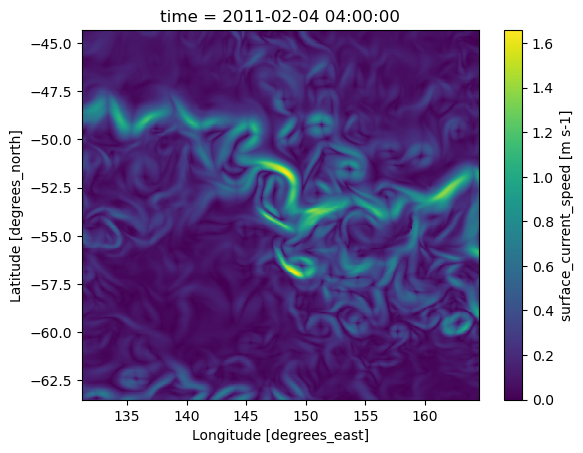

In [31]:
# Could try to install cftime for decoding time
try:
  import cftime
except ModuleNotFoundError:
  !pip install cftime
  import cftime

# load a sample file and plot
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    file = "current_speed.nc"
elif option == "remote":
    # do a local caching (downloads a file to cache)
    print("loading data remotely")
    file_loc = "https://github.com/julianmak/OCES3301_data_analysis/raw/refs/heads/main/current_speed.nc"
    file = fsspec.open_local(f"simplecache::{file_loc}", filecache={'cache_storage': '/tmp/fsspec_cache'})
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

# put decode_times=False as kwargs if cftime is not installed / imported
df = xr.open_dataset(file)
spd = df["speed"].isel(time=-1)  # pick out the last one for simplicity
spd.plot()